In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = "CS231n"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/CS231n


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import tqdm as tqdm
import Utils

import torch
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import scipy

In [5]:
import tensorflow as tf
import tensorflow 
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.regularizers import l2

In [6]:
def load_data(surface_path, target_path):
    targets = pd.read_csv(target_path, skiprows=2, parse_dates=True, index_col=0)
    targets = pd.DataFrame(targets['Close'])

    surfaces = pd.read_csv(surface_path, parse_dates=True, index_col=[0,1])

    dates = surfaces.index.get_level_values(0).unique()
    dates = pd.Series(list(set(targets.index).intersection(set(dates))))
    dates = dates.sort_values()


    targets = targets.loc[dates]
    surfaces = surfaces.loc[dates]
    return surfaces, targets

def target_volatility(surfaces, targets):
    rets = Utils.convert_to_daily_returns(targets)
    volatility = rets.rolling(window=60).std()*np.sqrt(252)
    dates = volatility.dropna().index
    return surfaces.loc[dates], volatility.dropna()


def stack_days(surfaces, targets, stacks):

    dim = len(surfaces.index.get_level_values(0).unique())
    dim1 = len(surfaces.index.get_level_values(1).unique())

    surfaces_np = surfaces.values.reshape((dim, dim1, surfaces.shape[1]))

    stacked_surfaces = np.zeros((len(surfaces_np)-stacks, dim1, surfaces.shape[1], stacks))
    
    for i in range(len(surfaces_np)-stacks):
        temp = np.stack(surfaces_np[i:i+stacks]).transpose(1,2,0)
        stacked_surfaces[i] = temp

    stacked_dates = surfaces.index.get_level_values(0).unique()[stacks:]
    
    return stacked_surfaces, targets.loc[stacked_dates], stacked_dates


def lag_targets(surfaces, targets, lag, dates):
    lagged = targets.shift(-lag)
    return surfaces[:-lag], lagged.dropna(), dates[lag:]


def train_test_split(test_start, test_end, dates, surfaces, targets):
    test_dates = pd.Series(dates, index=dates)[test_start:test_end]
    
    start_ind = dates.get_loc(test_dates.iloc[0])
    end_ind = dates.get_loc(test_dates.iloc[-1]) + 1
        
    surfaces_test = surfaces[start_ind:end_ind]
    targets_test = targets.to_numpy()[start_ind:end_ind]
    
    surfaces_train = surfaces[:start_ind]
    surfaces_train = np.concatenate((surfaces_train,surfaces[end_ind:]))

    targets_train = targets.to_numpy()[:start_ind]
    targets_train = np.concatenate((targets_train,targets.to_numpy()[end_ind:]))
    
    train_dates = pd.Series(dates, index=dates).loc[~pd.Series(dates, index=dates).index.isin(test_dates)].index
    
    return surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates
    
    
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [7]:
lag = 10
surfaces, targets = load_data("processed_data/SPX.csv", "data/VIX.csv")
stacked_surfaces, stacked_targets, dates = stack_days(surfaces, targets, 20)
stacked_surfaces, stacked_targets_lagged, dates = lag_targets(stacked_surfaces, stacked_targets, lag, dates)
surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates = train_test_split(
    '2019', '2023', dates, stacked_surfaces, stacked_targets_lagged)

In [8]:
input_shape = *surfaces_train[0].shape, 1
input_shape

(34, 11, 20, 1)

In [9]:
model = keras.models.Sequential()

model.add(layers.Conv3D(32, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(64, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.Conv3D(128, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(256, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))


#model.add(layers.BatchNormalization())


model.add(layers.Flatten())

model.add(layers.Dense(256, kernel_regularizer=l2(0.0005), activation='relu'))

model.add(layers.Dense(128, kernel_regularizer=l2(0.0005), activation='relu'))
#model.add(layers.Dropout(0.1))

model.add(layers.Dense(64, kernel_regularizer=l2(0.0005), activation='relu'))

model.add(layers.Dense(1, activation='linear'))

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(),
              metrics=[r_square, tf.keras.losses.Huber()])

K.set_value(model.optimizer.learning_rate, 0.005)

history = model.fit(surfaces_train, targets_train, epochs=50, batch_size=64)

Epoch 1/50
90/90 [==============================] - 6s 40ms/step - loss: 12.2124 - r_square: -35.5335 - huber_loss: 12.0194
Epoch 2/50
90/90 [==============================] - 3s 39ms/step - loss: 3.2059 - r_square: 0.6148 - huber_loss: 3.0462
Epoch 3/50
90/90 [==============================] - 4s 40ms/step - loss: 2.9212 - r_square: 0.6740 - huber_loss: 2.7780
Epoch 4/50
90/90 [==============================] - 4s 40ms/step - loss: 3.0448 - r_square: 0.6513 - huber_loss: 2.9094
Epoch 5/50
90/90 [==============================] - 3s 39ms/step - loss: 2.8626 - r_square: 0.6824 - huber_loss: 2.7339
Epoch 6/50
90/90 [==============================] - 3s 39ms/step - loss: 2.6422 - r_square: 0.7237 - huber_loss: 2.5201
Epoch 7/50
90/90 [==============================] - 3s 39ms/step - loss: 2.7402 - r_square: 0.7173 - huber_loss: 2.6205
Epoch 8/50
90/90 [==============================] - 3s 39ms/step - loss: 2.6928 - r_square: 0.7191 - huber_loss: 2.5776
Epoch 9/50
90/90 [==================

24/24 - 1s - loss: 3.4468 - r_square: -1.3710e+00 - huber_loss: 3.3920 - 626ms/epoch - 26ms/step


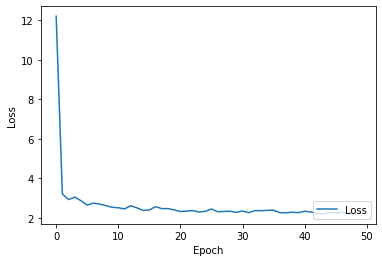

In [11]:
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

test_loss = model.evaluate(surfaces_test,  targets_test, verbose=2)

In [12]:
def plot_train_fit(surfaces_train, targets_train, dates_train):
        
    preds = model.predict(surfaces_train)
    print('R2: ')
    print(r2_score(targets_train, preds))
    print()
    
    print('MSE: ')
    print(mean_squared_error(targets_train, preds))
    print()
    
    test = pd.DataFrame(columns=['preds', 'targets'], index=dates_train)
    test['preds'] = preds
    test['targets'] = targets_train
    
    print('Corr: ')
    print(test.corr().iloc[0,1])
    print()
    
    print('Mean Absolute Error: ')
    print(np.abs(preds - targets_train).mean())
    print()
    
    print('Stdev Absolute Error: ')
    print(np.abs(preds - targets_train).std())
    print()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    plt.plot(dates_train, targets_train, label='Realized')
    plt.plot(dates_train, preds, label='Model')
    plt.legend()

R2: 
0.8010850315027536

MSE: 
15.048700400368118

Corr: 
0.9010408159308367

Mean Absolute Error: 
2.818020374455881

Stdev Absolute Error: 
2.665982289798575



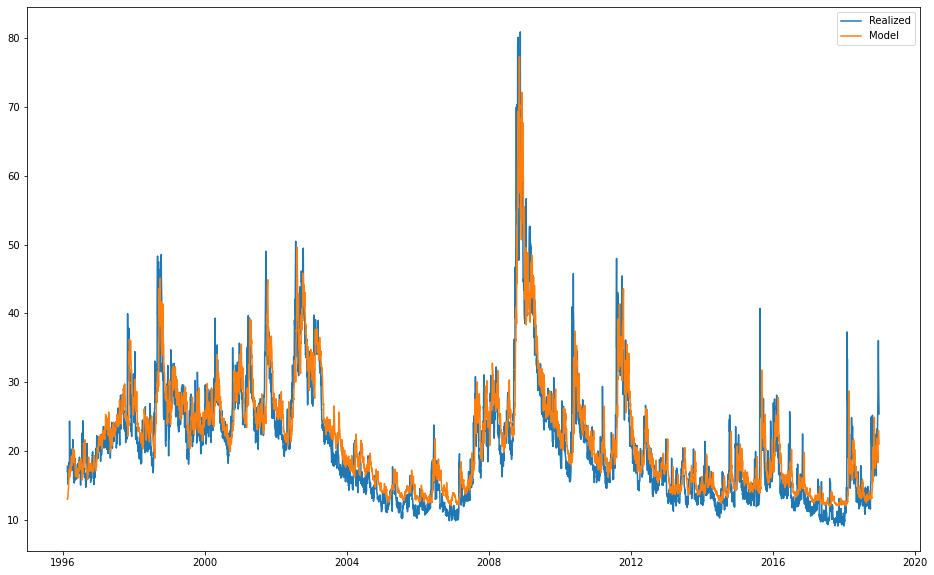

In [13]:
plot_train_fit(surfaces_train, targets_train, train_dates)

R2: 
0.46797684434042475

MSE: 
48.41477568461853

Corr: 
0.7076849127275309

Mean Absolute Error: 
3.8677115666424786

Stdev Absolute Error: 
5.784080127546517



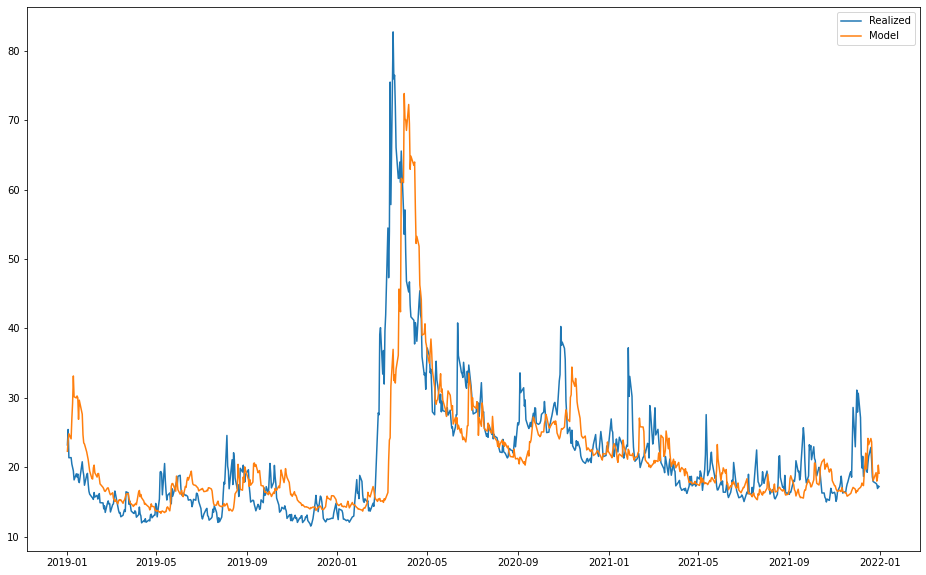

In [14]:
plot_train_fit(surfaces_test, targets_test, test_dates)

# Saliency maps

### Axes setup

In [15]:
days = [day for day in surfaces.index.unique(level=0)]
days_0 = days[0:20] ### Unsure
len(days)

6540

In [16]:
dates.shape
dates_0 = dates[0:20]

In [17]:
days_idx = [i for i in range(-20, 0)]

In [18]:
deltas = [delta for delta in surfaces.index.unique(level=1)]
len(deltas)

34

In [19]:
tenors = [int(tenor) for tenor in surfaces.columns]
len(tenors)

11

### Compute gradient

In [86]:
train_samp = surfaces_train[100]

In [87]:
input_samp_true = targets_train[10]

In [88]:
input_samp = tf.Variable(np.expand_dims(train_samp, [0, -1]), dtype=float)
input_samp_true = tf.Variable(targets_train[10], dtype=float)

with tf.GradientTape() as tape:
  input_samp_pred = model(input_samp, training=False)
  h = tf.keras.losses.Huber()
  loss = h(input_samp_true, input_samp_pred[0])
  # loss = tf.sqrt((input_samp_true - input_samp_pred[0])**2)

grads = tape.gradient(loss, input_samp)[0, :, :, :, 0]

### Delta-tenor surface

In [109]:
tenors_mesh, deltas_mesh = np.meshgrid(tenors, deltas)

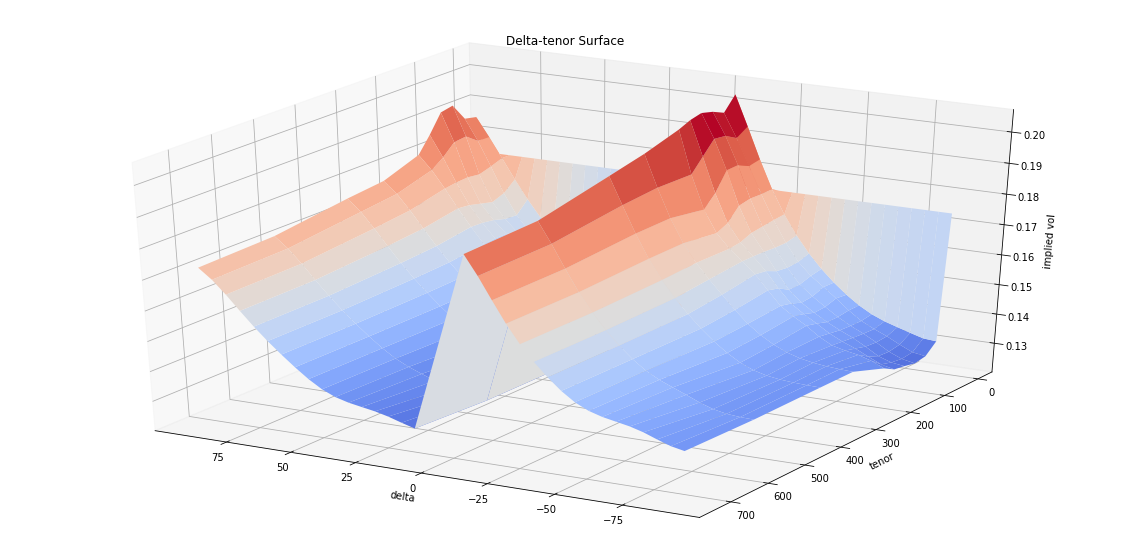

In [110]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(-140, -120)
ax.azim = 120 # https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib
ax.set_xlabel('delta')
ax.set_ylabel('tenor')
ax.set_zlabel('implied vol')
ax.set_title("Delta-tenor Surface")
_ = ax.plot_surface(deltas_mesh, tenors_mesh, train_samp[:, :, 5], cmap=cm.coolwarm)

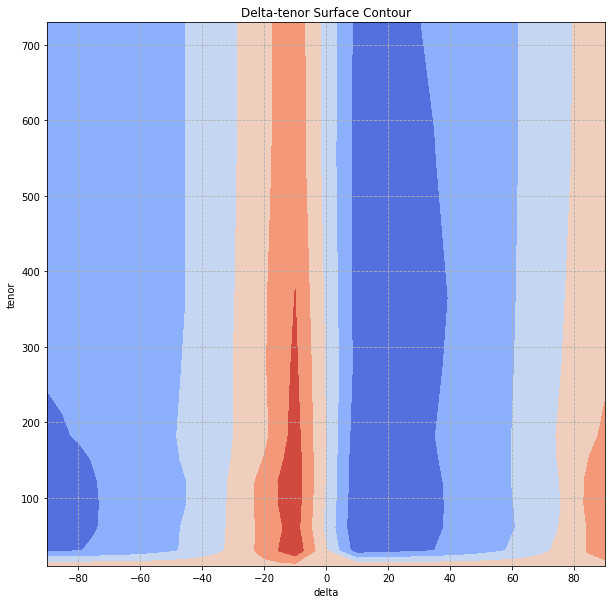

In [111]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('tenor')
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-tenor Surface Contour")
_ = ax.contourf(deltas_mesh, tenors_mesh, train_samp[:, :, 5], cmap=cm.coolwarm)

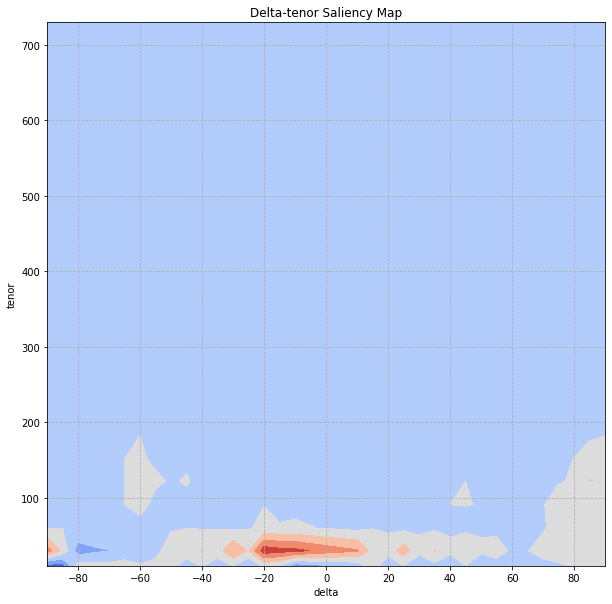

In [112]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('tenor')
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-tenor Saliency Map")
_ = ax.contourf(deltas_mesh, tenors_mesh, grads[:, :, 5], cmap=cm.coolwarm)

### Delta-lag surface

In [113]:
days_mesh, deltas_mesh = np.meshgrid(days_idx, deltas)

#### Lag 1

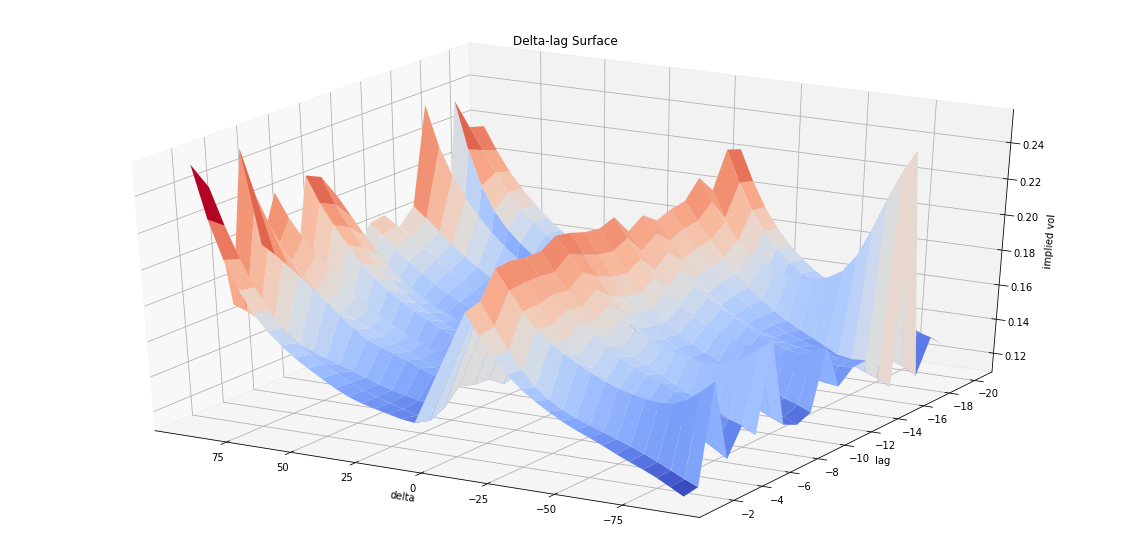

In [117]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.azim = 120
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_zlabel('implied vol')
ax.set_title("Delta-lag Surface")
ax.set_yticks(range(-20, 0, 2))
_ = ax.plot_surface(deltas_mesh, days_mesh, train_samp[:, 1, :], cmap=cm.coolwarm)

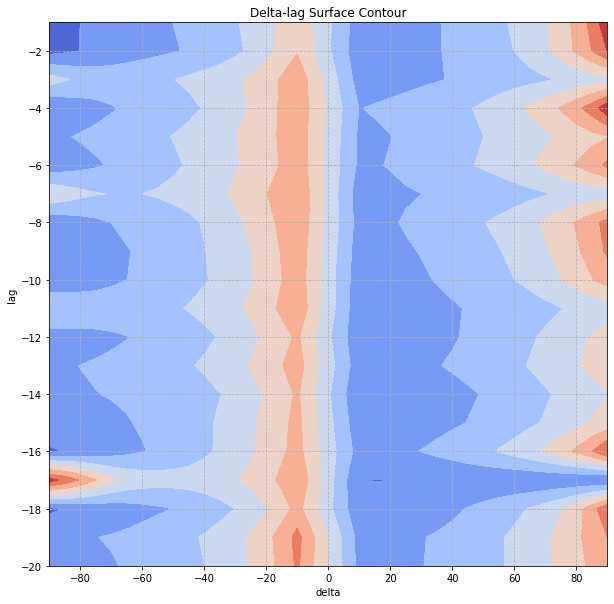

In [118]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_yticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-lag Surface Contour")
_ = ax.contourf(deltas_mesh, days_mesh, train_samp[:, 1, :], cmap=cm.coolwarm)

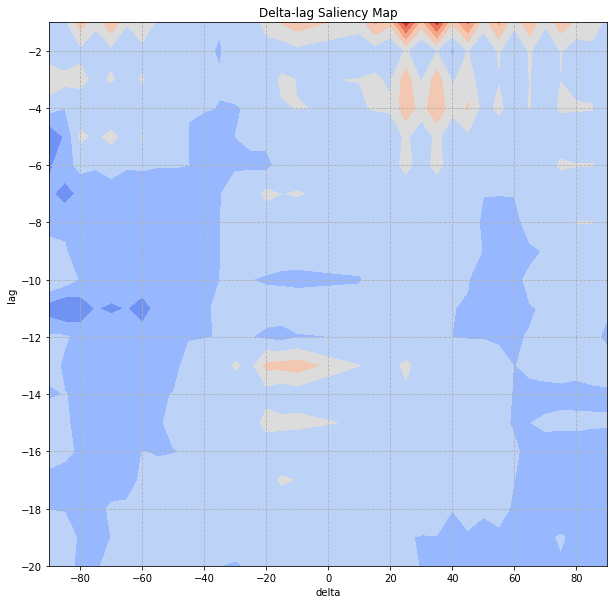

In [119]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_yticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-lag Saliency Map")
_ = ax.contourf(deltas_mesh, days_mesh, grads[:, 1, :], cmap=cm.coolwarm)

#### Lag 5

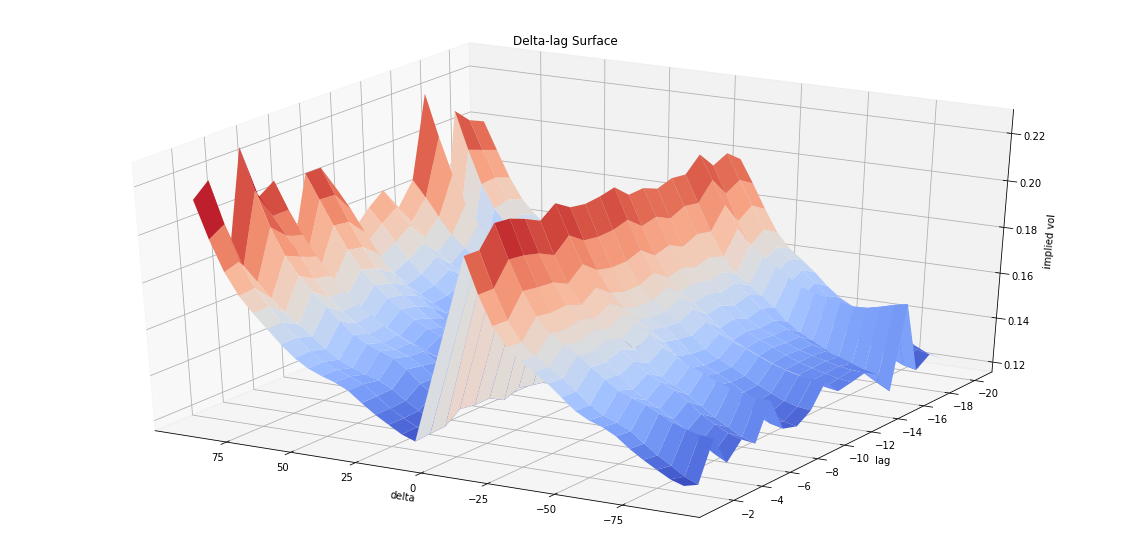

In [116]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.azim = 120
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_zlabel('implied vol')
ax.set_title("Delta-lag Surface")
ax.set_yticks(range(-20, 0, 2))
_ = ax.plot_surface(deltas_mesh, days_mesh, train_samp[:, 5, :], cmap=cm.coolwarm)

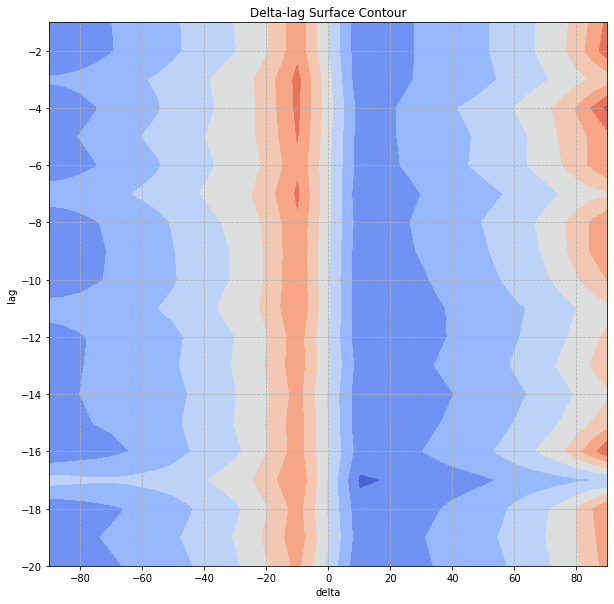

In [106]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_yticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-lag Surface Contour")
_ = ax.contourf(deltas_mesh, days_mesh, train_samp[:, 5, :], cmap=cm.coolwarm)

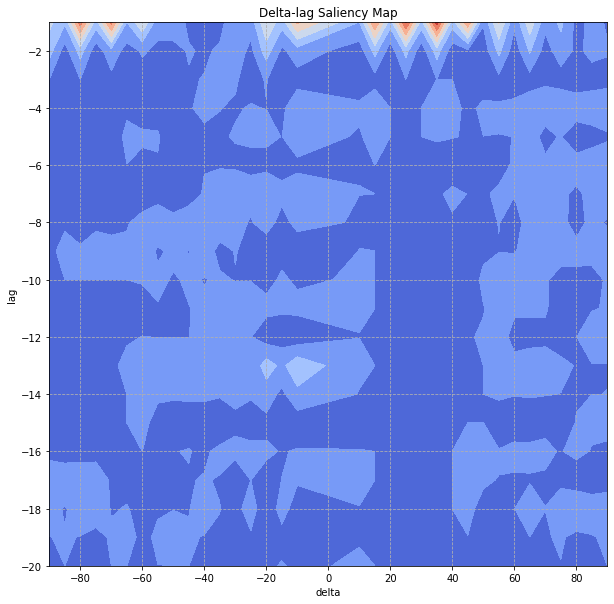

In [107]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_yticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-lag Saliency Map")
_ = ax.contourf(deltas_mesh, days_mesh, grads[:, 5, :], cmap=cm.coolwarm)

#### Lag 10

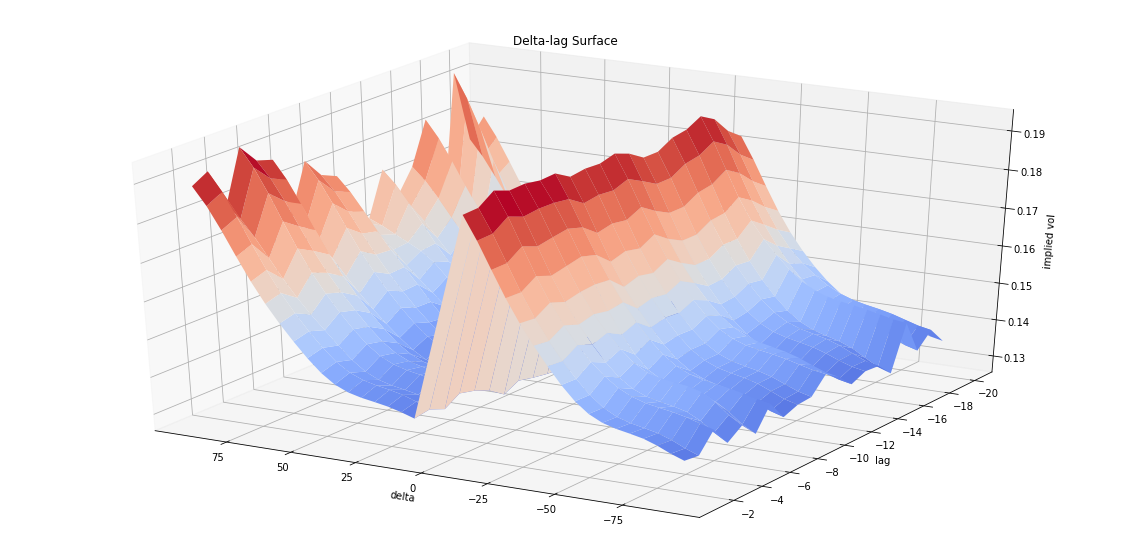

In [120]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.azim = 120
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_zlabel('implied vol')
ax.set_title("Delta-lag Surface")
ax.set_yticks(range(-20, 0, 2))
_ = ax.plot_surface(deltas_mesh, days_mesh, train_samp[:, 10, :], cmap=cm.coolwarm)

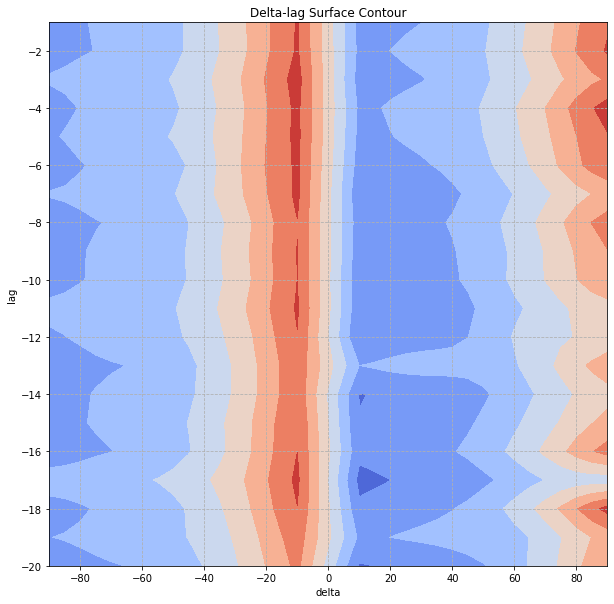

In [121]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_yticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-lag Surface Contour")
_ = ax.contourf(deltas_mesh, days_mesh, train_samp[:, 10, :], cmap=cm.coolwarm)

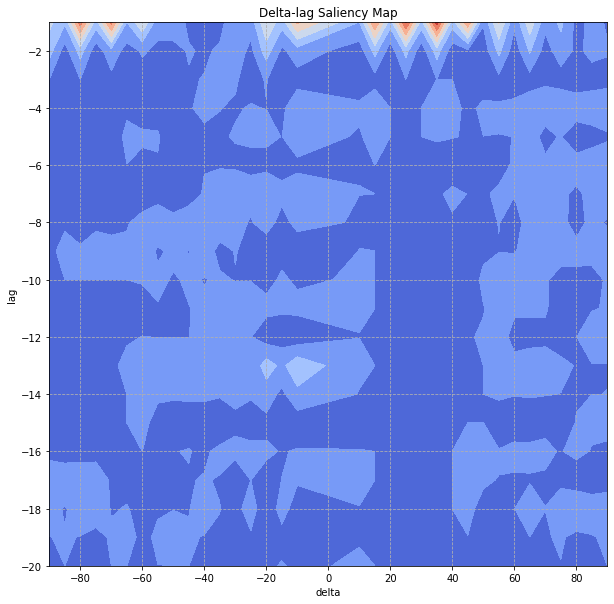

In [122]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('delta')
ax.set_ylabel('lag')
ax.set_yticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Delta-lag Saliency Map")
_ = ax.contourf(deltas_mesh, days_mesh, grads[:, 5, :], cmap=cm.coolwarm)

### Date-tenor surface

In [97]:
days_mesh, tenors_mesh = np.meshgrid(days_idx, tenors)

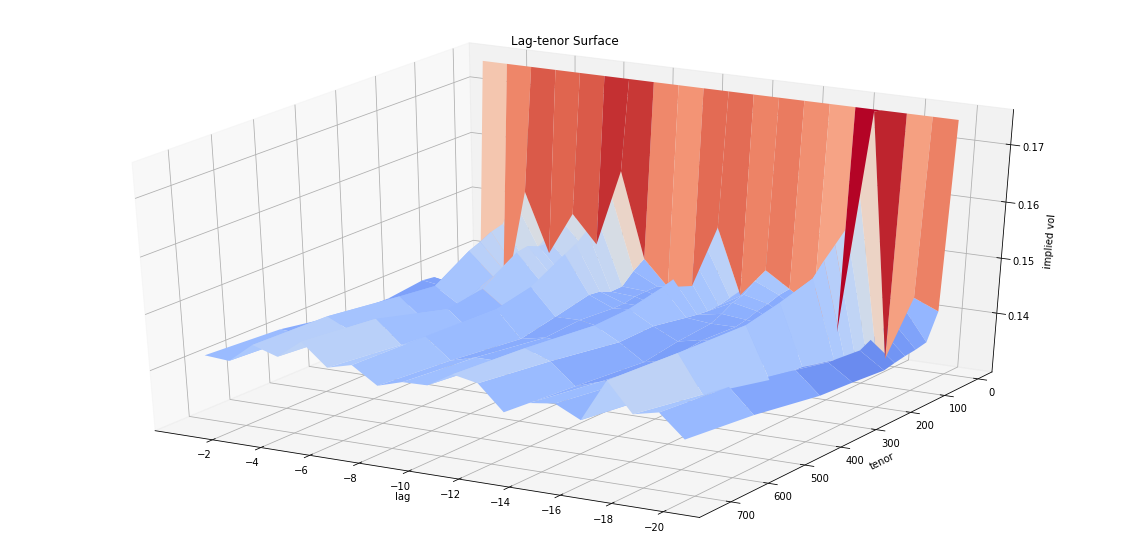

In [100]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.azim = 120
ax.set_xlabel('lag')
ax.set_ylabel('tenor')
ax.set_zlabel('implied vol')
ax.set_title("Lag-tenor Surface")
ax.set_xticks(range(-20, 0, 2))
_ = ax.plot_surface(days_mesh, tenors_mesh, train_samp[5, :, :], cmap=cm.coolwarm)

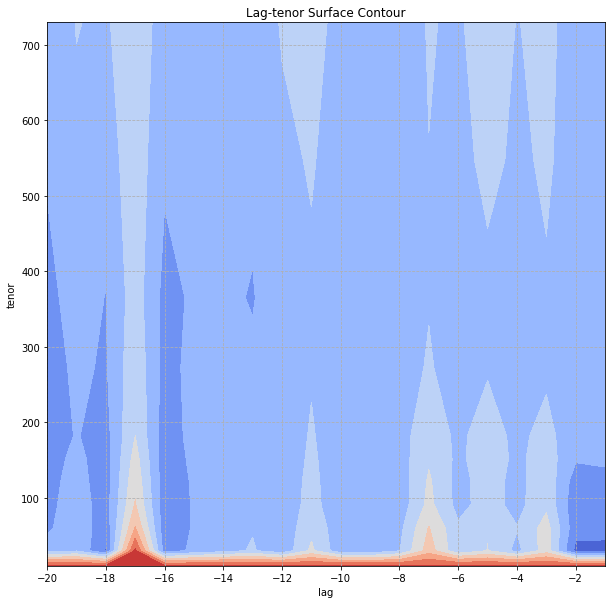

In [101]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('lag')
ax.set_ylabel('tenor')
ax.set_xticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Lag-tenor Surface Contour")
_ = ax.contourf(days_mesh, tenors_mesh, train_samp[5, :, :], cmap=cm.coolwarm)

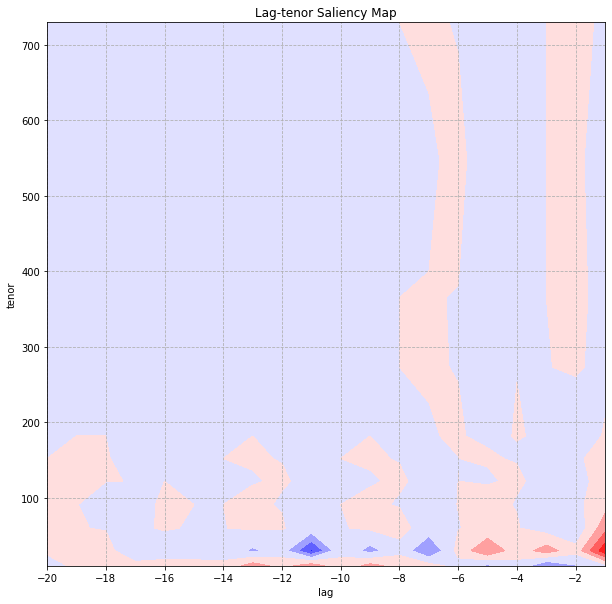

In [102]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('lag')
ax.set_ylabel('tenor')
ax.set_xticks(range(-20, 0, 2))
ax.grid(b=True, which='major', linestyle='--')
ax.set_title("Lag-tenor Saliency Map")
_ = ax.contourf(days_mesh, tenors_mesh, grads[5, :, :], cmap=cm.bwr)